In [27]:
import requests
from datetime import datetime, timedelta
import gzip
import csv
import xml.etree.ElementTree as ET
from tqdm import tqdm
import gc
import pandas as pd
import os

def download_vd_0000(directory, start, stop):
    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Convert start and stop into datetime objects
    start_date = datetime.strptime(start, '%Y%m%d')
    stop_date = datetime.strptime(stop, '%Y%m%d')
    
    # Generate dates within the range
    current_date = start_date
    while current_date <= stop_date:
        date_str = current_date.strftime('%Y%m%d')
        file_name = f"VD_{date_str}.xml.gz"
        url = f"https://tisvcloud.freeway.gov.tw/history/motc20/VD/{date_str}/VD_0000.xml.gz"
        
        try:
            # Attempt to download the file
            response = requests.get(url, stream=True)
            response.raise_for_status()  # Raises HTTPError for bad responses
            
            # Save the file
            with open(os.path.join(directory, file_name), 'wb') as file:
                for chunk in response.iter_content(chunk_size=8192): 
                    file.write(chunk)
            print(f"Downloaded {file_name}")
        except requests.exceptions.HTTPError as e:
            print(f"HTTP Error for {date_str}: {e}")
        except requests.exceptions.ConnectionError as e:
            print(f"Connection Error for {date_str}: {e}")
        except Exception as e:
            print(f"Unexpected error for {date_str}: {e}")
        
        # Move to the next day
        current_date += timedelta(days=1)


def decompress(directory):
    # Iterate through all files in the specified directory
    for filename in os.listdir(directory):
        # Check if the file is a .gz file
        if filename.endswith(".gz"):
            gz_path = os.path.join(directory, filename)
            xml_path = os.path.join(directory, filename[:-3])  # Remove '.gz' to get the XML file path
            
            try:
                # Decompress the .gz file
                with gzip.open(gz_path, 'rb') as gz_file:
                    with open(xml_path, 'wb') as xml_file:
                        xml_file.write(gz_file.read())
                
                # Delete the .gz file upon successful decompression
                os.remove(gz_path)
                print(f"Successfully decompressed and removed: {filename}")
            
            except OSError as e:
                print(f"Error decompressing file {filename}: {e}")
            except Exception as e:
                print(f"Unexpected error with file {filename}: {e}")




def xml_to_csv(directory_path, csv_directory_path):
    # Ensure the CSV directory exists
    if not os.path.exists(csv_directory_path):
        os.makedirs(csv_directory_path)
    
    # Find all XML files in the directory
    xml_files = [f for f in os.listdir(directory_path) if f.endswith('.xml')]
    
    # Initialize the progress bar
    progress_bar = tqdm(xml_files, desc="Processing XML files")

    for xml_file in progress_bar:
        xml_file_path = os.path.join(directory_path, xml_file)
        base_filename = os.path.splitext(xml_file)[0]
        csv_file_path = os.path.join(csv_directory_path, f"{base_filename}.csv")
        
        # Initialize variables for each file
        column_names = []
        data_rows = []

        try:
            # Parse the XML file
            tree = ET.parse(xml_file_path)
            root = tree.getroot()

            # Define the recursive data extraction function here
            def extract_data(element, path=''):
                nonlocal column_names
                data = {}
                for attr_name, attr_value in element.attrib.items():
                    col_name = f'{path}{element.tag.split("}")[-1]}.{attr_name}'
                    data[col_name] = attr_value
                    if col_name not in column_names:
                        column_names.append(col_name)
                
                if element.text and element.text.strip():
                    col_name = f'{path}{element.tag.split("}")[-1]}'
                    data[col_name] = element.text.strip()
                    if col_name not in column_names:
                        column_names.append(col_name)
                
                for child in element:
                    child_data = extract_data(child, path=f'{element.tag.split("}")[-1]}.')
                    data.update(child_data)
                return data

            # Extract data from each <VD> element
            for vd in root.findall('.//{http://traffic.transportdata.tw/standard/traffic/schema/}VD'):
                row_data = extract_data(vd)
                data_rows.append(row_data)

            # Write data to CSV file for the current XML
            with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
                writer = csv.DictWriter(file, fieldnames=column_names)
                writer.writeheader()
                for row in data_rows:
                    writer.writerow(row)
        
        except ET.ParseError as e:
            progress_bar.write(f"XML parse error in {xml_file}: {e}")
        except IOError as e:
            progress_bar.write(f"Error writing to {csv_file_path}: {e}")
        except Exception as e:
            progress_bar.write(f"Unexpected error with {xml_file}: {e}")


def process_csv_files(directory_path):
    # Define input and output directories based on the provided date
    input_directory = os.path.join(directory_path, "csv")
    output_directory = os.path.join(directory_path, "VDID")

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Initialize an empty list to store DataFrames
    dfs = []

    # List all CSV files in the input directory
    csv_files = [f for f in os.listdir(input_directory) if f.endswith('.csv')]
    
    print(f"Processing {len(csv_files)} CSV files:")
    
    with tqdm(total=len(csv_files), unit='file') as pbar_files:
        for filename in csv_files:
            try:
                # Read the CSV file and insert the 'file_name' column at the beginning
                df = pd.read_csv(os.path.join(input_directory, filename))
                df.insert(0, 'file_name', filename)
                
                # Append the DataFrame to the list
                dfs.append(df)
                
                pbar_files.update(1)
            except Exception as e:
                # Print an error message and continue processing other files
                print(f'Error processing file {filename}: {e}')

    # Concatenate all DataFrames in the list to create the combined DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)

    # Clear the list of individual DataFrames to release memory
    dfs.clear()
    gc.collect()  # Manually trigger garbage collection

    # Group the combined DataFrame by 'VDID'
    groups = combined_df.groupby('VD.VDID')
    
    print(f"\nSaving {len(groups)} VDID-specific CSV files:")
    
    with tqdm(total=len(groups), unit='VDID') as pbar_vdids:
        for vdid, group_df in groups:
            try:
                # Save the group-specific data to a CSV file in the output directory
                group_df.to_csv(os.path.join(output_directory, f'{vdid}.csv'), index=False)
                
                pbar_vdids.update(1)
            except Exception as e:
                # Print an error message if saving fails
                print(f'Error saving VDID {vdid}: {e}')
    
    print(f"\n{len(groups)} VDID-specific CSV files saved.")

    # Clear variables holding large data and manually collect garbage again
    del combined_df, groups
    gc.collect()


In [28]:
directory_path = r"C:\Users\galen\Downloads\VD_0000\vd"
csv_directory_path = r"C:\Users\galen\Downloads\VD_0000\csv"
#download_vd_0000(directory, '20230101', '20231231')
#decompress(directory)
#xml_to_csv(directory_path, csv_directory_path)
#process_csv_files(r"C:\Users\galen\Downloads\VD_0000")

Processing 365 CSV files:


100%|██████████| 365/365 [00:04<00:00, 86.66file/s]



Saving 4260 VDID-specific CSV files:


100%|██████████| 4260/4260 [00:15<00:00, 270.33VDID/s]



4260 VDID-specific CSV files saved.


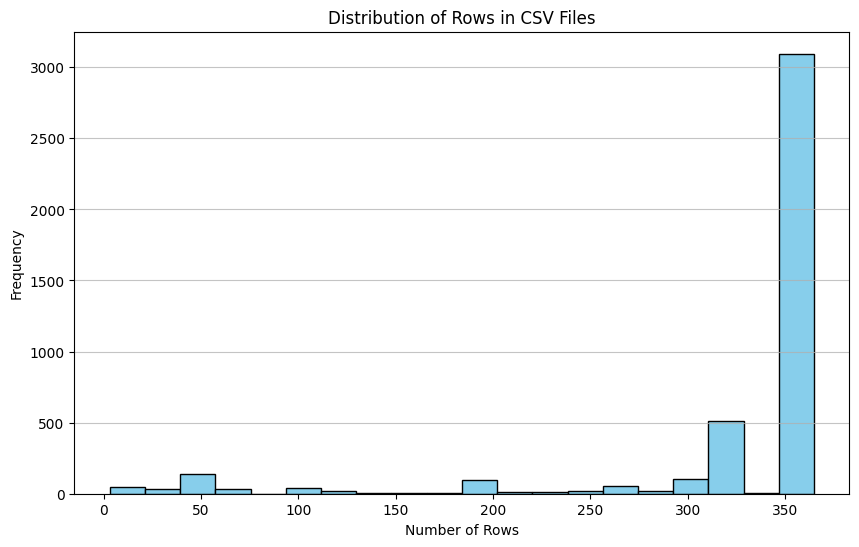

Analysis result saved to: C:\Users\galen\Downloads\VD_0000\VDID\csv_row_analysis.csv


In [31]:
#!pip install matplotlib
import matplotlib.pyplot as plt
import pandas as pd

def analyze_csv_rows(folder_path):
    # List for storing file names and row counts
    data = []

    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            
            try:
                # Count the number of rows in the CSV file
                with open(file_path, 'r', encoding='utf-8') as f:
                    row_count = sum(1 for row in f) - 1  # Subtract 1 for the header row
                data.append((filename, row_count))
            except Exception as e:
                print(f"Error processing file {filename}: {e}")
    
    # Convert data to a DataFrame
    df = pd.DataFrame(data, columns=["File name", "Number of rows"])
    
    # Generate a histogram
    plt.figure(figsize=(10, 6))
    plt.hist(df["Number of rows"], bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribution of Rows in CSV Files")
    plt.xlabel("Number of Rows")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()
    
    # Save the data to a new CSV file
    output_path = os.path.join(folder_path, "csv_row_analysis.csv")
    df.to_csv(output_path, index=False)
    
    return output_path

# Example usage
result_path = analyze_csv_rows(r"C:\Users\galen\Downloads\VD_0000\VDID")
print(f"Analysis result saved to: {result_path}")

# This function is designed to be run in a local environment. Adjust the folder path to point to your CSV files.